### Import required libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("wordnet")
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load the data

In [2]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    return data


file_path = r"C:\Users\win\Desktop\Data_Science\4th_sem\Applied_ML\spam_detection\emails.csv"
df = load_data(file_path)

In [3]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


#### Exploratory Data Analysis

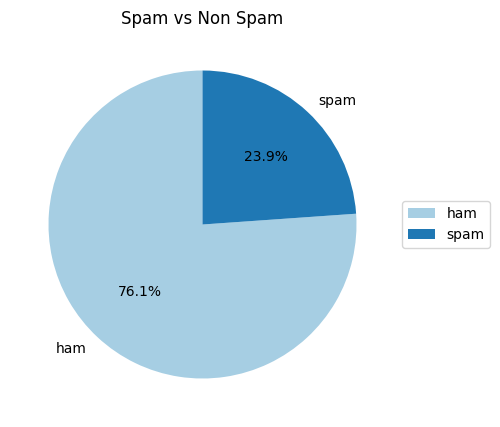

In [4]:
categories = df['spam'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(5, 5))
plt.pie(categories, labels=['ham','spam'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Spam vs Non Spam')

# Show the legend on the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

#### split the each text into number of words and add it to the data frame

In [5]:
df['no_of_words'] = df['text'].str.split().apply(len)

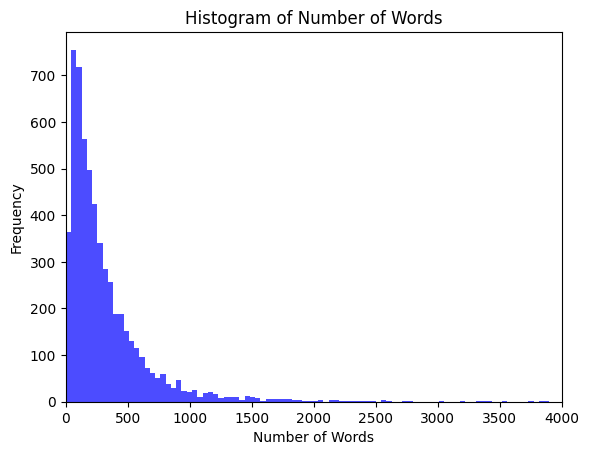

In [6]:
plt.hist(df['no_of_words'], bins=200, color='blue', alpha=0.7)
plt.title('Histogram of Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 4000)  # Set x-axis limits
plt.show()

#### test for the impact of number of words on spam detection

In [7]:
from scipy.stats import ttest_ind

# Separate data into two groups based on binary class
ham = df[df['spam'] == 0]['no_of_words']
spam = df[df['spam'] == 1]['no_of_words']

# Perform t-test
t_stat, p_value = ttest_ind(ham, spam)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Interpret the result
alpha = 0.05  # significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference between the groups.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference between the groups.')


T-statistic: 6.135560397893373
P-value: 9.054449732264912e-10
Reject the null hypothesis: There is a significant difference between the groups.


In [8]:
df.groupby('spam').describe()

no_of_words                                                           
           count        mean         std  min    25%    50%     75%     max
spam                                                                       
0         4360.0  345.804817  406.189568  2.0  119.0  239.0  439.25  8477.0
1         1368.0  266.432749  451.461674  4.0   79.0  139.5  251.00  6129.0

#### The average number of words in ham mails are greater than spam mails. and also in the spam mails the variation is very high

In [9]:
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('re')

def preprocess_spam_data(data):
    # Convert to lowercase
    data['text'] = data['text'].str.lower()

    # Remove punctuation
    data['text'] = data['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    ## remove numbers from the text column
    data["text"] = data["text"].apply(lambda x: re.sub(r"\d+", "", x))

    # Tokenize
    data['text'] = data['text'].apply(word_tokenize)

    # Remove stop words
    data['text'] = data['text'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    data['text'] = data['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    ## remove single character words
    data["text"] = data["text"].apply(lambda x: [word for word in x if len(word)>1])

    # Join tokens back into strings
    data['text'] = data['text'].apply(lambda x: ' '.join(x))

    return data


In [10]:
df_mod = preprocess_spam_data (df)

In [11]:
df_mod

,text,spam,no_of_words
0,naturally irresistible corporate identity lt r...,1,324
1,stock trading gunslinger fanny merrill muzo co...,1,89
2,unbelievable new home made easy im wanting sho...,1,87
3,color printing special request additional info...,1,98
4,money get software cd software compatibility g...,1,52
...,...,...,...
5723,research development charge gpg forwarded shir...,0,297
5724,receipt visit jim thanks invitation visit lsu ...,0,244
5725,enron case study update wow day super thank mu...,0,515
5726,interest david please call shirley crenshaw as...,0,276


In [12]:
def display_wordcloud(words):

    wordcloud_spam = WordCloud(width = 500, height = 300, background_color = "white").generate(words)
    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud_spam, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

def wordcloud():
    spam_words = df_mod[df_mod["spam"] == 1].text.str.cat(sep = " ")
    ham_words = df_mod[df_mod["spam"] == 0].text.str.cat(sep = " ")

    print("WordCloud of Spam words:")
    display_wordcloud(spam_words)

    print("WordCloud of Ham Words:")
    display_wordcloud(ham_words)


WordCloud of Spam words:


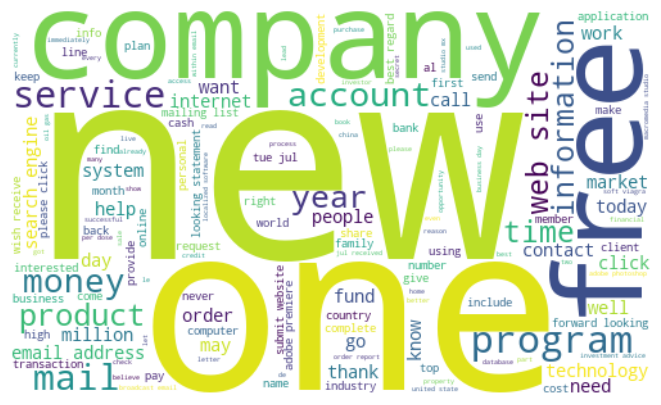

WordCloud of Ham Words:


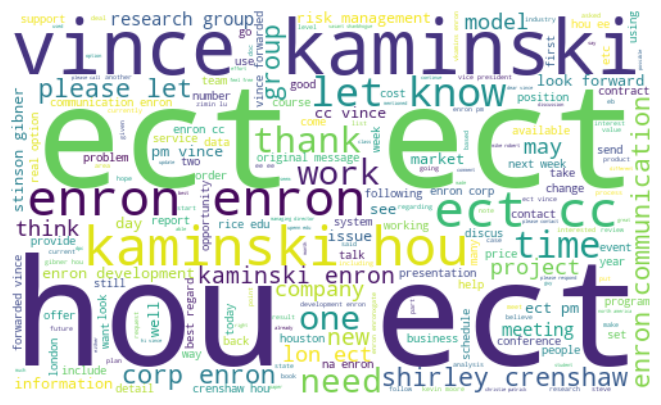

In [13]:
wordcloud()

### Train Validation Test Split

In [14]:
def train_val_test(data):
    X_train, X_test, y_train, y_test = train_test_split(data.drop("spam", axis = 1), data["spam"], test_size = 0.20, random_state = 42, stratify = data['spam'])
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.13, random_state = 42)

    train = pd.concat([X_train, y_train], axis = 1, join = "inner")
    val = pd.concat([X_val, y_val], axis = 1, join = "inner")
    test = pd.concat([X_test, y_test], axis = 1, join = "inner")

    print("Shapes of Train Validation Test split: ")
    print("Train shape {}".format((train.shape)))
    print("Validation shape {}".format((val.shape)))
    print("Test shape {}".format((test.shape)))

    return train, val, test

In [15]:
train, validation, test = train_val_test(df_mod)

Shapes of Train Validation Test split: 
Train shape (3986, 3)
Validation shape (596, 3)
Test shape (1146, 3)


#### Store the data in .csv files

In [16]:
train.to_csv("train.csv", header = True, index = False)
validation.to_csv("validation.csv", header = True, index = False)
test.to_csv("test.csv", header = True, index = False)